This notebook was implemented to
- compute the *correlation networks* for the three examined experimental conditions: **epi** (Episome), **m11** (macroH2A1.1), and **m12** (macroH2A1.2);
- summarize the obtained networks and the counts of genes belonging to **NHEJ**, **DDR not NHEJ**, **Reprogramming**, and **Senescence** pathways, which we represented as bar plots;
- export the three biggest m11 networks as SIF and attribute files for easy representation in Cytoscape, since m11 demonstrated to contain most of the genes belonging to NHEJ in its biggest subnetworks (sizes **24, 36, 62**).
- finally compute a one-way ANOVA among all conditions (m11, m12, episome) and select the significantly most varying genes to be represented by heatmap

In [4]:
import os.path
import math

import pandas as pd
import numpy as np
from IPython.display import display

from multiprocessing import Pool
from functools import partial

# Importing gene expression data

In [5]:
if os.path.exists("./playgrounds/data/NAR_2021/CTL_vs_macroH2A11_epi.xlsx"):
    m11_file = "./playgrounds/data/NAR_2021/CTL_vs_macroH2A11_epi.xlsx"
    m11_file_huv = './playgrounds/data/NAR_2021/HUVEC_vs_macroH2A11_epi.xlsx'
    m12_file = "./playgrounds/data/NAR_2021/CTL_vs_macroH2A12_epi.xlsx"
    m11_vs_m12_file = "./playgrounds/data/NAR_2021/macroH2A11_epi_vs_macroH2A12_epi.xlsx"
    gene_lists =  pd.read_excel("./playgrounds/data/NAR_2021/gene_lists_24012021.xls", sheet_name="lists")
    
    import macroH2A_IPS_NAR_2021_workers
elif not os.path.exists("./data/NAR_2021/CTL_vs_macroH2A11_epi.xlsx"):
    ## Conditional branch for Google Colab
    !git clone https://github.com/mazzalab/playgrounds.git
    m11_file = "./playgrounds/data/NAR_2021/CTL_vs_macroH2A11_epi.xlsx"
    m11_file_huv = './playgrounds/data/NAR_2021/HUVEC_vs_macroH2A11_epi.xlsx'
    m12_file = "./playgrounds/data/NAR_2021/CTL_vs_macroH2A12_epi.xlsx"
    m11_vs_m12_file = "./playgrounds/data/NAR_2021/macroH2A11_epi_vs_macroH2A12_epi.xlsx"
    gene_lists =  pd.read_excel("./playgrounds/data/NAR_2021/gene_lists_24012021.xls", sheet_name="lists")
    
    ## Import the worker function for parallel computing
    import playgrounds.macroH2A_IPS_NAR_2021_workers
    ## Install Pyntacle
    !pip install pyntacle==1.3.2
else:
    m11_file = "data/NAR_2021/CTL_vs_macroH2A11_epi.xlsx"
    m11_file_huv = 'data/NAR_2021/HUVEC_vs_macroH2A11_epi.xlsx'
    m12_file = "data/NAR_2021/CTL_vs_macroH2A12_epi.xlsx"
    m11_vs_m12_file = "data/NAR_2021/macroH2A11_epi_vs_macroH2A12_epi.xlsx"
    gene_lists =  pd.read_excel("data/NAR_2021/gene_lists_24012021.xls", sheet_name="lists")
    
    import macroH2A_IPS_NAR_2021_workers
    
m11_m12_epi = pd.read_excel(m11_file, sheet_name="CTL_vs_macroH2A11_epi", 
                            index_col=None, na_values=['NA'], usecols = "A,C,J:R", engine='openpyxl')
m11_m12_epi = m11_m12_epi.loc[m11_m12_epi['gene_biotype'] == "protein_coding"]

m11_m12_huv = pd.read_excel(m11_file_huv, sheet_name="HUVEC_vs_macroH2A11_epi", 
                            index_col=None, na_values=['NA'], usecols = "A,C,M:U", engine='openpyxl')
m11_m12_huv = m11_m12_huv.loc[m11_m12_huv['gene_biotype'] == "protein_coding"]

epi_vs_m11 = pd.read_excel(m11_file, sheet_name="CTL_vs_macroH2A11_epi", 
                           index_col=None, na_values=['NA'], usecols = "A,E,H", engine='openpyxl')
epi_vs_m12 = pd.read_excel(m12_file, sheet_name="CTL_vs_macroH2A12_epi", 
                           index_col=None, na_values=['NA'], usecols = "A,E,H", engine='openpyxl')
m11_vs_m12 = pd.read_excel(m11_vs_m12_file, sheet_name="macroH2A11+epi vs macroH2A12+ep", 
                           index_col=None, na_values=['NA'], usecols = "A,E,H", engine='openpyxl')

display(m11_m12_epi.head())

,Gene Symbol,gene_biotype,EPI,3_I,3_II,1_1_1,1_1_2,1_1_3,2_I,2_II,2_III
0,TBC1D3L,protein_coding,7.148288,0.000000,36.919539,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,DNAH5,protein_coding,21.165576,11.080615,12.798294,0.0,0.395609,0.751568,4.215694,2.008978,2.188068
7,SAP25,protein_coding,0.000000,7.201708,7.178799,0.0,0.000000,0.000000,8.870301,0.000000,0.000000
10,EYA1,protein_coding,0.000000,25.060854,0.000000,0.0,0.741551,0.000000,0.000000,0.318718,0.000000
11,CYP39A1,protein_coding,0.000000,0.528252,15.767867,0.0,0.000000,0.000000,0.000000,15.017370,0.000000


# Analysis of relationships

## macroH2A1.1

In [10]:
temp = m11_m12_epi.iloc[:,5:8]
temp.index = m11_m12_epi.iloc[:,0]

# remove genes with more than one zero
temp = temp[(temp == 0).sum(1) < 2]

In [ ]:
num_processors = 5

#Create a pool of processors
p=Pool(processes = num_processors)
func = partial(macroH2A_IPS_NAR_2021_workers.range_calc_Cor, temp)

chunklen = math.ceil(temp.shape[0] / num_processors)
chunks = [range(0, temp.shape[0])[i * chunklen:(i + 1) * chunklen] for i in range(num_processors)]

#get them to work in parallel - highly intensive !!
output = p.map(func, [chunk for chunk in chunks])
# output = p.map(func, [i for i in range(0, temp.shape[0])])
p.close()

m11_cor = np.vstack(output)
print(m11_cor)

In [5]:
m11_cor_df = pd.DataFrame (m11_cor)
m11_cor_df.columns = temp.index
m11_cor_df = m11_cor_df.set_index(temp.index)
m11_cor_df.to_csv("m11_cor_df.txt", sep="\t", header=True, index=True)

## macroH2A1.2

In [9]:
temp = m11_m12_huv.iloc[:,8:11]
temp.index = m11_m12_huv.iloc[:,0]

# remove genes more than one zero
temp = temp[(temp == 0).sum(1) < 2]

In [10]:
num_processors = 5

#Create a pool of processors
p=Pool(processes = num_processors)
func = partial(macroH2A_IPS_NAR_2021_workers.range_calc_Cor, temp)

chunklen = math.ceil(temp.shape[0] / num_processors)
chunks = [range(0, temp.shape[0])[i * chunklen:(i + 1) * chunklen] for i in range(num_processors)]

#get them to work in parallel - highly intensive !!
output = p.map(func, [chunk for chunk in chunks])
p.close()

m12_cor = np.vstack(output)
print(m12_cor)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 -0.9975208980091912 -0.9976873881590403]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0.9998810590275212 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [11]:
m12_cor_df = pd.DataFrame (m12_cor)
m12_cor_df.columns = temp.index
m12_cor_df = m12_cor_df.set_index(temp.index)
m12_cor_df.to_csv("m12_cor_df.txt", sep="\t", header=True, index=True)

## Episome

In [5]:
temp = m11_m12_epi.iloc[:,2:5]
temp.index = m11_m12_epi.iloc[:,0]

# remove genes that contain more than one zero
temp = temp[(temp == 0).sum(1) < 2]
temp.head()

,EPI,3_I,3_II
Gene Symbol,,,
TBC1D3L,7.148288,0.000000,36.919539
DNAH5,21.165576,11.080615,12.798294
SAP25,0.000000,7.201708,7.178799
CYP39A1,0.000000,0.528252,15.767867
KCNMA1,2.125832,6.211489,12.575072


In [6]:
num_processors = 5

#Create a pool of processors
p=Pool(processes = num_processors)
func = partial(macroH2A_IPS_NAR_2021_workers.range_calc_Cor, temp)

chunklen = math.ceil(temp.shape[0] / num_processors)
chunks = [range(0, temp.shape[0])[i * chunklen:(i + 1) * chunklen] for i in range(num_processors)]

#get them to work in parallel - highly intensive !!
output = p.map(func, [chunk for chunk in chunks])
p.close()

epi_cor = np.vstack(output)
print(epi_cor)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 (-0.9979656578155047, 0.04061446866363006) 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
epi_cor_df = pd.DataFrame(epi_cor)
epi_cor_df.columns = temp.index
epi_cor_df = epi_cor_df.set_index(temp.index)
epi_cor_df.to_csv("epi_cor_df.txt", sep="\t", header=True, index=True)

## Format and filter datasets

In [65]:
## Load from file if needed
# m11_cor_df = pd.read_csv("m11_cor_df.txt", sep="\t", dtype=object, index_col='Genes')
# m12_cor_df = pd.read_csv("m12_cor_df.txt", sep="\t", dtype=object, index_col='Genes')
# epi_cor_df = pd.read_csv("epi_cor_df.txt", sep="\t", dtype=object, index_col='Genes')

### Episome

In [67]:
epi_cor_conn_df = epi_cor_df.reset_index().melt(id_vars='Genes').query('value != 0')
epi_cor_conn_df = epi_cor_conn_df[epi_cor_conn_df['value']!='0']

epi_cor_conn_df.set_index(epi_cor_conn_df['Genes'], inplace=True)
epi_cor_conn_df['value2'] = [eval(x) for x in epi_cor_conn_df['value'].to_numpy()]
epi_cor_conn_df[['b1', 'b2']] = pd.DataFrame(epi_cor_conn_df['value2'].tolist(), index=epi_cor_conn_df.index)
epi_cor_conn_df = epi_cor_conn_df.drop(['value', 'value2'], axis=1)
epi_cor_conn_df.columns = ["Gene Symbol A", "Gene Symbol B", "Corr", "p_value"]
epi_cor_conn_df[['adj_p_value']] = macroH2A_IPS_NAR_2021_workers.fdr(epi_cor_conn_df['p_value'])

epi_cor_conn_df = epi_cor_conn_df[(epi_cor_conn_df['adj_p_value'] <0.01)]

epi_cor_conn_df.to_csv("epi_cor_conn_filtered.txt", sep="\t", header=True, index=True)
epi_cor_conn_df.head()

### macroH2A1.1

In [ ]:
m11_cor_conn_df = m11_cor_df.reset_index().melt(id_vars='Genes').query('value != 0')
m11_cor_conn_df = m11_cor_conn_df[m11_cor_conn_df['value']!='0']

m11_cor_conn_df.set_index(m11_cor_conn_df['Genes'], inplace=True)
m11_cor_conn_df['value2'] = [eval(x) for x in m11_cor_conn_df['value'].to_numpy()]
m11_cor_conn_df[['b1', 'b2']] = pd.DataFrame(m11_cor_conn_df['value2'].tolist(), index=m11_cor_conn_df.index)
m11_cor_conn_df = m11_cor_conn_df.drop(['value', 'value2'], axis=1)
m11_cor_conn_df.columns = ["Gene Symbol A", "Gene Symbol B", "Corr", "p_value"]
m11_cor_conn_df[['adj_p_value']] = macroH2A_IPS_NAR_2021_workers.fdr(m11_cor_conn_df['p_value'])

m11_cor_conn_df = m11_cor_conn_df[(m11_cor_conn_df['adj_p_value'] <0.01)]

m11_cor_conn_df.to_csv("m11_cor_conn_filtered.txt", sep="\t", header=True, index=True)
m11_cor_conn_df.head()

### macroH2A1.2

In [ ]:
m12_cor_conn_df = m12_cor_df.reset_index().melt(id_vars='Genes').query('value != 0')
m12_cor_conn_df = m12_cor_conn_df[m12_cor_conn_df['value']!='0']

m12_cor_conn_df.set_index(m12_cor_conn_df['Genes'], inplace=True)
m12_cor_conn_df['value2'] = [eval(x) for x in m12_cor_conn_df['value'].to_numpy()]
m12_cor_conn_df[['b1', 'b2']] = pd.DataFrame(m12_cor_conn_df['value2'].tolist(), index=m12_cor_conn_df.index)
m12_cor_conn_df = m12_cor_conn_df.drop(['value', 'value2'], axis=1)
m12_cor_conn_df.columns = ["Gene Symbol A", "Gene Symbol B", "Corr", "p_value"]
m12_cor_conn_df[['adj_p_value']] = macroH2A_IPS_NAR_2021_workers.fdr(m12_cor_conn_df['p_value'])

m12_cor_conn_df = m12_cor_conn_df[(m12_cor_conn_df['adj_p_value'] <0.01)]

m12_cor_conn_df.to_csv("m12_cor_conn_filtered.txt", sep="\t", header=True, index=True)
m12_cor_conn_df.head()

# Plotting results

In [135]:
from pyntacle.io_stream.importer import PyntacleImporter
g_epi = PyntacleImporter.Sif("epi_cor_conn_filtered.sif")
g_m11 = PyntacleImporter.Sif("m11_cor_conn_filtered_df.sif")
g_m12 = PyntacleImporter.Sif("m12_cor_conn_filtered_df.sif")

SIF from epi_cor_conn_filtered.sif imported
SIF from m11_cor_conn_filtered_df.sif imported
SIF from m12_cor_conn_filtered_df.sif imported


## Select components that contain at least one gene of the lists above

In [227]:
cc_epi = g_epi.clusters()
cc_epi = [c.vs["name"] for c in cc_epi.subgraphs() if c.vcount() >2 and 
          (set(c.vs["name"]).intersection(gene_lists['NHEJ'].tolist()) or 
           (set(c.vs["name"]).intersection(gene_lists['Senescence'].tolist())) or 
           (set(c.vs["name"]).intersection(gene_lists['Reprogramming'].tolist())) or 
           (set(c.vs["name"]).intersection(gene_lists['DDR_not_NHEJ'].tolist()))
          )]

cc_m11 = g_m11.clusters()
cc_m11 = [c.vs["name"] for c in cc_m11.subgraphs() if c.vcount() >2 and 
          (set(c.vs["name"]).intersection(gene_lists['NHEJ'].tolist()) or 
           (set(c.vs["name"]).intersection(gene_lists['Senescence'].tolist())) or 
           (set(c.vs["name"]).intersection(gene_lists['Reprogramming'].tolist())) or 
           (set(c.vs["name"]).intersection(gene_lists['DDR_not_NHEJ'].tolist()))
          )]

cc_m12 = g_m12.clusters()
cc_m12 = [c.vs["name"] for c in cc_m12.subgraphs() if c.vcount() >2 and 
          (set(c.vs["name"]).intersection(gene_lists['NHEJ'].tolist()) or 
           (set(c.vs["name"]).intersection(gene_lists['Senescence'].tolist())) or 
           (set(c.vs["name"]).intersection(gene_lists['Reprogramming'].tolist())) or 
           (set(c.vs["name"]).intersection(gene_lists['DDR_not_NHEJ'].tolist()))
          )]


In [270]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

plt.rcParams.update({'figure.figsize':(2.8,1.5), 'figure.dpi':300})
plt.rcParams.update({'font.size': 7})

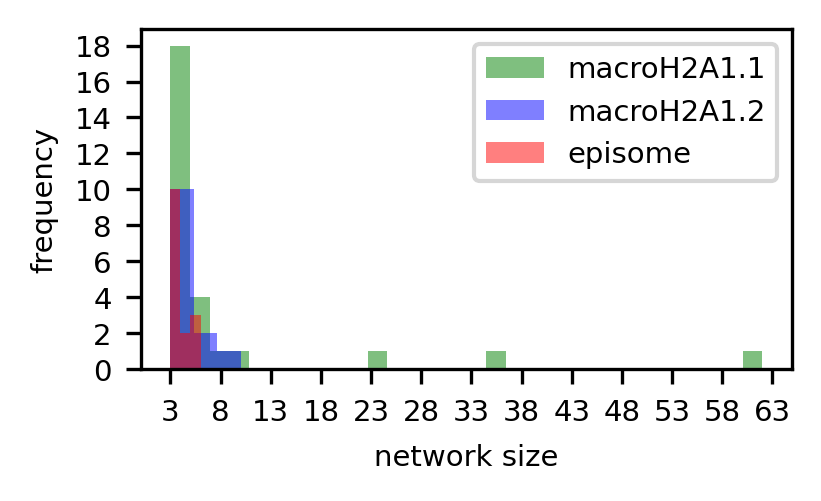

In [229]:
kwargs_m11 = dict(alpha=0.5, bins=30)
kwargs_m12 = dict(alpha=0.5, bins=3)
kwargs_epi = dict(alpha=0.5, bins=3)

temp_cc_m11 = [len(c) for c in cc_m11]
temp_cc_m12 = [len(c) for c in cc_m12]
temp_cc_epi = [len(c) for c in cc_epi]

plt.hist(temp_cc_m11, **kwargs_m11, color='g', label='macroH2A1.1')
plt.hist(temp_cc_m12, **kwargs_m12, color='b', label='macroH2A1.2')
plt.hist(temp_cc_epi, **kwargs_epi, color='r', label='episome')

plt.gca().set(ylabel='frequency', xlabel='network size')  # title='Frequency Histogram', 
plt.xticks(np.arange(min(min(temp_cc_m11), min(temp_cc_epi), min(temp_cc_m12)), 
                     max(max(temp_cc_m11), max(temp_cc_epi), max(temp_cc_m12))+2, 
                     5))
plt.yticks(np.arange(0,20,2))

# plt.xlim(50,75)
plt.legend()

plt.savefig("FigureXX_A.svg")

## Count genes in gene lists for the clusters of sizes > 2 of mH2A1.1 co-expression network

In [254]:
cc_m11 = g_m11.clusters()
cc_m11_ddr_not_nhej = [(set(c.vs["name"]).intersection(gene_lists['DDR_not_NHEJ'].tolist()), len(c.vs["name"])) 
               for c 
               in cc_m11.subgraphs() if c.vcount() >2 and set(c.vs["name"]).intersection(gene_lists['DDR_not_NHEJ'].tolist())]

cc_m11_nhej = [(set(c.vs["name"]).intersection(gene_lists['NHEJ'].tolist()), len(c.vs["name"])) 
               for c 
               in cc_m11.subgraphs() if c.vcount() >2 and set(c.vs["name"]).intersection(gene_lists['NHEJ'].tolist())]

cc_m11_reprogramming = [(set(c.vs["name"]).intersection(gene_lists['Reprogramming'].tolist()), len(c.vs["name"])) 
               for c 
               in cc_m11.subgraphs() if c.vcount() >2 and set(c.vs["name"]).intersection(gene_lists['Reprogramming'].tolist())]

cc_m11_senescence = [(set(c.vs["name"]).intersection(gene_lists['Senescence'].tolist()), len(c.vs["name"])) 
               for c 
               in cc_m11.subgraphs() if c.vcount() >2 and set(c.vs["name"]).intersection(gene_lists['Senescence'].tolist())]

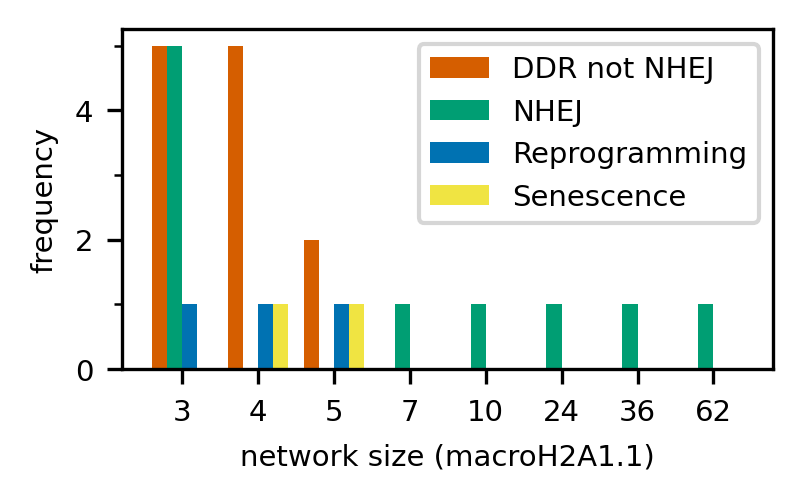

In [291]:
from collections import Counter

z = [x[1] for x in cc_m11_ddr_not_nhej]
counter_cc_m11_ddr_not_nhej = Counter(z)

z = [x[1] for x in cc_m11_nhej]
counter_cc_m11_nhej = Counter(z)

z = [x[1] for x in cc_m11_reprogramming]
counter_cc_m11_reprogramming = Counter(z)

z = [x[1] for x in cc_m11_senescence]
counter_cc_m11_senescence = Counter(z)

labels = counter_cc_m11_ddr_not_nhej + counter_cc_m11_reprogramming + counter_cc_m11_nhej + counter_cc_m11_senescence
# labels.most_common()
labels = [x[0] for x in sorted(labels.items())]
zero_dict = dict(zip(labels, [0] * len(labels)))

dict_cc_m11_ddr_not_nhej = {**zero_dict, **counter_cc_m11_ddr_not_nhej}
dict_cc_m11_nhej = {**zero_dict, **counter_cc_m11_nhej}
dict_cc_m11_reprogramming = {**zero_dict, **counter_cc_m11_reprogramming}
dict_cc_m11_senescence = {**zero_dict, **counter_cc_m11_senescence}

counts_m11_ddr_not_nhej = list(dict_cc_m11_ddr_not_nhej.values())
counts_cc_m11_nhej = list(dict_cc_m11_nhej.values())
counts_cc_m11_reprogramming = list(dict_cc_m11_reprogramming.values())
counts_cc_m11_senescence = list(dict_cc_m11_senescence.values())

x = np.arange(len(labels))  # the label locations
width = 0.20

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*2, counts_m11_ddr_not_nhej, width, label='DDR not NHEJ', align='edge', color='#d55e00')
rects2 = ax.bar(x - width, counts_cc_m11_nhej, width, label='NHEJ', align='edge', color='#009e73')
rects3 = ax.bar(x, counts_cc_m11_reprogramming, width, label='Reprogramming', align='edge', color='#0072b2')
rects4 = ax.bar(x + width, counts_cc_m11_senescence, width, label='Senescence', align='edge', color='#f0e442')

ax.set_ylabel('frequency')
ax.set_xlabel('network size (macroH2A1.1)')
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

plt.savefig("FigureXX_B.svg")

## Create network (sif) and attribute files for cluster (size 62) of macroH2A1.1

In [323]:
cc_m11 = g_m11.clusters()
cc_m11_62 = [c for c in cc_m11.subgraphs() if c.vcount() == 62][0]
cc_m11_62_nodes = pd.DataFrame(cc_m11_62.vs["name"])
cc_m11_62_nodes = cc_m11_62_nodes.rename(columns={0: 'Node'})
cc_m11_62_nodes[["NHEJ"]] = [c in gene_lists['NHEJ'].tolist() for c in cc_m11_62_nodes['Node']]
cc_m11_62_nodes[["DDR_not_NHEJ"]] = [c in gene_lists['DDR_not_NHEJ'].tolist() for c in cc_m11_62_nodes['Node']]
cc_m11_62_nodes[["Reprogramming"]] = [c in gene_lists['Reprogramming'].tolist() for c in cc_m11_62_nodes['Node']]
cc_m11_62_nodes[["Senescence"]] = [c in gene_lists['Senescence'].tolist() for c in cc_m11_62_nodes['Node']]

diff_expr = [x['Gene Symbol'] for index, x in epi_vs_m11.iterrows() if 
             x['pvalue']<0.05 and (x['log2FoldChange'] > 1 or x['log2FoldChange'] < -1)]
cc_m11_62_nodes[["DEG"]] = [c['Node'] in diff_expr for index2, c in cc_m11_62_nodes.iterrows()]

cc_m11_62_nodes.to_csv("g_m11_62_nodes_attributes.tsv", index = False, header=True, sep='\t')
cc_m11_62_nodes.head()

from pyntacle.io_stream.exporter import PyntacleExporter
PyntacleExporter.Sif(file='g_m11_62.sif', graph=cc_m11_62, header=True)

Graph successfully exported to SIF at full path:
/scratch/tom/playgrounds/g_m11_62.sif


## Create network (sif) and attribute files for cluster (size 36) of macroH2A1.1

In [373]:
cc_m11_36 = [c for c in cc_m11.subgraphs() if c.vcount() == 36][0]
cc_m11_36_nodes = pd.DataFrame(cc_m11_36.vs["name"])
cc_m11_36_nodes = cc_m11_36_nodes.rename(columns={0: 'Node'})
cc_m11_36_nodes[["NHEJ"]] = [c in gene_lists['NHEJ'].tolist() for c in cc_m11_36_nodes['Node']]
cc_m11_36_nodes[["DDR_not_NHEJ"]] = [c in gene_lists['DDR_not_NHEJ'].tolist() for c in cc_m11_36_nodes['Node']]
cc_m11_36_nodes[["Reprogramming"]] = [c in gene_lists['Reprogramming'].tolist() for c in cc_m11_36_nodes['Node']]
cc_m11_36_nodes[["Senescence"]] = [c in gene_lists['Senescence'].tolist() for c in cc_m11_36_nodes['Node']]

diff_expr = [x['Gene Symbol'] for index, x in epi_vs_m11.iterrows() if 
             x['pvalue']<0.05 and (x['log2FoldChange'] > 1 or x['log2FoldChange'] < -1)]
cc_m11_36_nodes[["DEG"]] = [c['Node'] in diff_expr for index2, c in cc_m11_36_nodes.iterrows()]

cc_m11_36_nodes.to_csv("g_m11_36_nodes_attributes.tsv", index = False, header=True, sep='\t')
cc_m11_36_nodes.head()

from pyntacle.io_stream.exporter import PyntacleExporter
PyntacleExporter.Sif(file='g_m11_36.sif', graph=cc_m11_36, header=True)

Graph successfully exported to SIF at full path:
/scratch/tom/playgrounds/g_m11_36.sif


## Create network (sif) and attribute files for cluster (size 24) of macroH2A1.1

In [380]:
cc_m11_24 = [c for c in cc_m11.subgraphs() if c.vcount() == 24][1]
cc_m11_24_nodes = pd.DataFrame(cc_m11_24.vs["name"])
cc_m11_24_nodes = cc_m11_24_nodes.rename(columns={0: 'Node'})
cc_m11_24_nodes[["NHEJ"]] = [c in gene_lists['NHEJ'].tolist() for c in cc_m11_24_nodes['Node']]
cc_m11_24_nodes[["DDR_not_NHEJ"]] = [c in gene_lists['DDR_not_NHEJ'].tolist() for c in cc_m11_24_nodes['Node']]
cc_m11_24_nodes[["Reprogramming"]] = [c in gene_lists['Reprogramming'].tolist() for c in cc_m11_24_nodes['Node']]
cc_m11_24_nodes[["Senescence"]] = [c in gene_lists['Senescence'].tolist() for c in cc_m11_24_nodes['Node']]

diff_expr = [x['Gene Symbol'] for index, x in epi_vs_m11.iterrows() if 
             x['pvalue']<0.05 and (x['log2FoldChange'] > 1 or x['log2FoldChange'] < -1)]
cc_m11_24_nodes[["DEG"]] = [c['Node'] in diff_expr for index2, c in cc_m11_24_nodes.iterrows()]

cc_m11_24_nodes.to_csv("g_m11_24_nodes_attributes.tsv", index = False, header=True, sep='\t')
cc_m11_24_nodes.head()

from pyntacle.io_stream.exporter import PyntacleExporter
PyntacleExporter.Sif(file='g_m11_24.sif', graph=cc_m11_24, header=True)

Graph successfully exported to SIF at full path:
/scratch/tom/playgrounds/g_m11_24.sif


## Compute ANOVA among all conditions (m11, m12, episome)

In [324]:
m11_m12_epi.head()

,Gene Symbol,gene_biotype,EPI,3_I,3_II,1_1_1,1_1_2,1_1_3,2_I,2_II,2_III
0,TBC1D3L,protein_coding,7.148288,0.000000,36.919539,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,DNAH5,protein_coding,21.165576,11.080615,12.798294,0.0,0.395609,0.751568,4.215694,2.008978,2.188068
7,SAP25,protein_coding,0.000000,7.201708,7.178799,0.0,0.000000,0.000000,8.870301,0.000000,0.000000
10,EYA1,protein_coding,0.000000,25.060854,0.000000,0.0,0.741551,0.000000,0.000000,0.318718,0.000000
11,CYP39A1,protein_coding,0.000000,0.528252,15.767867,0.0,0.000000,0.000000,0.000000,15.017370,0.000000


In [357]:
import scipy.stats as stats

In [348]:
temp = pd.DataFrame(index = m11_m12_epi.index, columns = ['fvalue', 'pvalue'])
for idx, row in m11_m12_epi.iterrows():
    temp.at[idx,'fvalue'], temp.at[idx,'pvalue'] = stats.f_oneway(row[2:5], row[5:8], row[7:11])
    
m11_m12_epi_anova = pd.concat([m11_m12_epi, temp], axis=1)
m11_m12_epi_anova[['adj_pvalue']] = macroH2A_IPS_NAR_2021_workers.fdr(m11_m12_epi_anova['pvalue'])
m11_m12_epi_anova.head()

/home/t.mazza/miniconda3/envs/playgrounds/lib/python3.7/site-packages/scipy/stats/stats.py:3709: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


,Gene Symbol,gene_biotype,EPI,3_I,3_II,1_1_1,1_1_2,1_1_3,2_I,2_II,2_III,fvalue,pvalue,adj_pvalue
0,TBC1D3L,protein_coding,7.148288,0.000000,36.919539,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.06819,0.196896,0.655542
4,DNAH5,protein_coding,21.165576,11.080615,12.798294,0.0,0.395609,0.751568,4.215694,2.008978,2.188068,21.1798,0.00107409,1
7,SAP25,protein_coding,0.000000,7.201708,7.178799,0.0,0.000000,0.000000,8.870301,0.000000,0.000000,1.29337,0.332655,0.732052
10,EYA1,protein_coding,0.000000,25.060854,0.000000,0.0,0.741551,0.000000,0.000000,0.318718,0.000000,1.18013,0.361688,0.705583
11,CYP39A1,protein_coding,0.000000,0.528252,15.767867,0.0,0.000000,0.000000,0.000000,15.017370,0.000000,0.49759,0.627978,0.826801


## Print data for Heatmap

In [365]:
temp4hm = m11_m12_epi_anova[m11_m12_epi_anova['pvalue']<= 0.05]
temp4hm = temp4hm.drop(['gene_biotype', 'fvalue', 'pvalue', 'adj_pvalue'], axis=1)
temp4hm.head()

temp4hm.to_csv("m11_m12_epi_4hm.txt", sep="\t", header=True, index=False)

## Compute ANOVA among all conditions (m11, m12, episome)

In [349]:
temp = pd.DataFrame(index = m11_m12_huv.index, columns = ['fvalue', 'pvalue'])
for idx, row in m11_m12_huv.iterrows():
    temp.at[idx,'fvalue'], temp.at[idx,'pvalue'] = stats.f_oneway(row[2:5], row[5:8], row[7:11])
    
m11_m12_huv_anova = pd.concat([m11_m12_huv, temp], axis=1)
m11_m12_huv_anova[['adj_pvalue']] = macroH2A_IPS_NAR_2021_workers.fdr(m11_m12_huv_anova['pvalue'])
del temp
m11_m12_huv_anova.head()


/home/t.mazza/miniconda3/envs/playgrounds/lib/python3.7/site-packages/scipy/stats/stats.py:3709: F_onewayConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(F_onewayConstantInputWarning())


,Gene Symbol,gene_biotype,1_1_1,1_1_2,1_1_3,2_I,2_II,2_III,HU-1,HU-2,HU-3,fvalue,pvalue,adj_pvalue
0,DLL4,protein_coding,1.967663,0.000000,0.000000,4.888776,3.875864,1.055344,171.317048,159.895481,131.157147,5.91105,0.0313693,0.140032
1,A2M,protein_coding,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.713592,42.028808,35.046734,5.77696,0.0329851,0.144026
2,FABP4,protein_coding,8.925116,5.769943,4.567326,10.841104,24.417390,22.339012,1600.273607,1421.770685,1531.110873,6.34627,0.0267785,0.131111
3,CXCR4,protein_coding,0.991714,8.655214,8.221472,16.755013,102.556588,37.232976,1526.319178,1319.388751,1293.156542,6.24151,0.0278001,0.132937
4,IL33,protein_coding,1.917317,4.845609,0.883048,0.952738,11.779960,0.000000,422.037827,405.282691,365.291858,6.0656,0.029631,0.136465


## Compute ANOVA among all conditions (m11, m12, HUVEC)

In [366]:
temp4hm = m11_m12_huv_anova[m11_m12_huv_anova['adj_pvalue']<= 0.05]
temp4hm = temp4hm.drop(['gene_biotype', 'fvalue', 'pvalue', 'adj_pvalue'], axis=1)
temp4hm.head()

temp4hm.to_csv("m11_m12_huv_4hm.txt", sep="\t", header=True, index=False)
del temp4hm

# Print system and required packages information

In [6]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,matplotlib,sklearn,traitlets,IPython,ipywidgets,openpyxl,pyntacle

# date
print(" ")
%watermark -u -n -t -z

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
pandas 1.1.4
matplotlib 3.1.3
sklearn 0.24.0
traitlets 4.3.3
IPython 7.12.0
ipywidgets 7.5.1
openpyxl 3.0.3
pyntacle 1.3.2

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
 
last updated: Mon Mar 08 2021 17:36:33 W. Europe Standard Time
